In [1]:
import os
import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from enum import StrEnum

plt.rcdefaults()
plt.rc('axes.formatter', use_mathtext=True)
plt.rc('figure', dpi=100)
font = {
    'family' : 'serif',
    'size'   : 12,
    'serif':  'cmr10'
}
plt.rc('font', **font)

np.set_printoptions(suppress=True)

In [2]:
# colors
class Color(StrEnum):
    LeNet = "green"
    AlexNet = "blue"
    AlexNetVIB = "black"
    AlexNetMCDO = "red"
    AlexNetTH_VIB = "orange"
    VGG = "dodgerblue"
    ResNet = "saddlebrown"
    RatS = "#1F77B4" 
    RanS = "#FF7F0E" 
    EntS = "#2CA02C"
    MarS = "#D62728" 
    VRS =  "#9467BD" 
    LCS =  "#8C564B"

    @classmethod
    def from_model_name(cls, model_name):
        return cls[model_name].value

In [3]:
def replace_customnet(model_name):
    if model_name == "CustomNet":
        return "AlexNetTH_VIB"
    return model_name

In [4]:
def get_query_path_stg(test_or_train_path:str = "train", file_regex: str = "500-**"):

    al_path = f"/workspace/result/active_learning/{test_or_train_path}"
    model_paths = os.listdir(al_path)
    query_path_stg = {}

    for model_path in model_paths:
        model_dir = os.path.join(al_path, model_path)
        query_paths = os.listdir(model_dir)
        
        query_path_stg[model_path] = {} 

        for query_path in query_paths:
            query_dir = os.path.join(model_dir, query_path)
            query_path_stg[model_path][query_path] = glob.glob(os.path.join(query_dir, file_regex, "*.csv"), recursive=True)
    
    return query_path_stg

In [5]:
train_path = "/workspace/result/train"
model_paths = os.listdir(train_path)
model_path_stg = {}
for model_path in model_paths:
    model_path_stg[model_path] = glob.glob(f"{train_path}/{model_path}/**data**/**.csv", recursive=True)

train_dfs = {} 
for model, path in model_path_stg.items():
    train_dfs[model] = [pd.read_csv(filename, index_col=None, header=0) for filename in model_path_stg[model]]

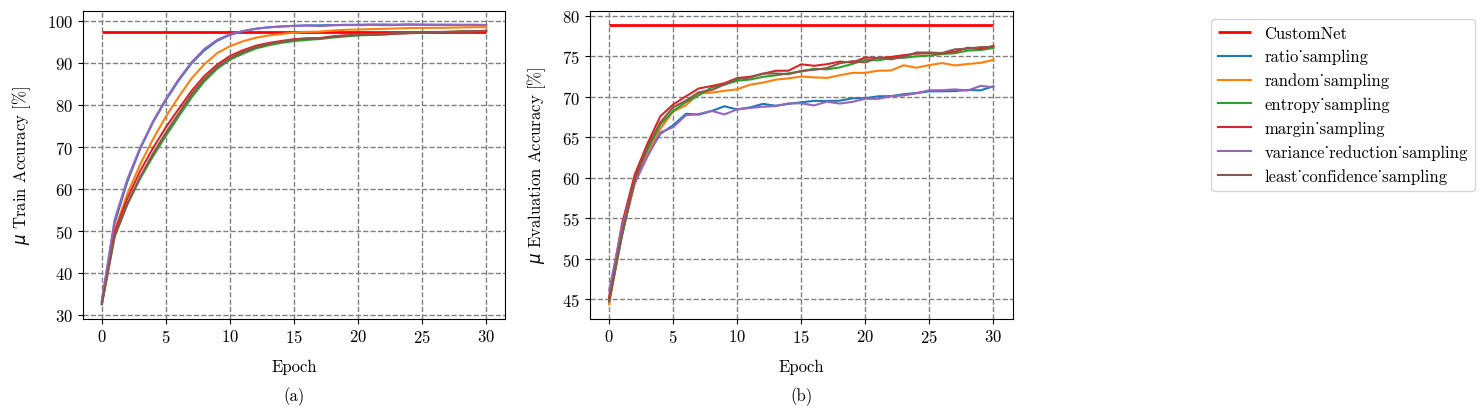

In [6]:
al_train_dfs = {} 
query_path_stg = get_query_path_stg()
for query_strategy, query_path in query_path_stg["CustomNet"].items():
    al_train_dfs[query_strategy] = [pd.read_csv(filename, index_col=None, header=0) for filename in query_path_stg["CustomNet"][query_strategy]]


fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,4), sharex=True)
axes = axes.flatten()

cols = ["Train Accuracy", "Evaluation Accuracy"]
labels = ["(a)", "(b)", "(c)", "(d)", "(e)", "(f)", "(g)" ]


for idx, col in enumerate(cols):
    ax = axes[idx]

    _col = col
    if col == "Evaluation Accuracy":
        _col = "Validation Accuracy"
    df_mean = np.mean([df[_col].values for df in train_dfs["CustomNet"]], axis=0) 
    ax.hlines(df_mean[-1], xmin=0, xmax=30, linewidth=2, color='r', label="CustomNet")


    for qs_name, df_s in al_train_dfs.items():

        qs_name = replace_customnet(model_name=qs_name)
        df_mean = np.mean([df[col].values for df in df_s], axis=0) 
        # print(model_name, np.round(df_mean[-1], 2))
        ax.plot(range(len(df_mean)), df_mean, label=qs_name)

    ax.grid(True, which='both', axis='both', color='gray', linestyle='--', linewidth=1)  # Dashed grid
    # ax.minorticks_on()  # Enable minor ticks
    # ax.grid(True, which='minor', linestyle='--', linewidth=0.5)  # Minor grid lines with dotted style

    ax.set_xlabel("Epoch", fontsize=12, labelpad=10)
    ax.text(0.5, -0.22, labels[idx], transform=ax.transAxes, fontsize=12, fontweight='bold',  ha='center', va='top')
    ax.set_ylabel(fr"$\mu$ {col} [%]", fontsize=12, labelpad=10)
    # ax.set_ylim([-5,105])
# plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
# plt.xlabel("Epoch", fontsize=12, labelpad=10)
plt.legend(loc='best', bbox_to_anchor=(1.45, 1))
plt.show()

In [7]:

short_sampling_name = {
    'ratio_sampling': 'RatS', 
    'random_sampling': 'RanS', 
    'entropy_sampling': 'EntS', 
    'margin_sampling': 'MarS', 
    'variance_reduction_sampling': 'VRS', 
    'least_confidence_sampling': 'LCS'
}

Model: AlexNetTH_VIB
ratio_sampling (71.31)
random_sampling (74.55)
entropy_sampling (76.02)
margin_sampling (76.29)
variance_reduction_sampling (71.17)
least_confidence_sampling (76.15)
Model: AlexNetMCDO
ratio_sampling (75.62)
random_sampling (80.76)
entropy_sampling (82.56)
margin_sampling (82.68)
variance_reduction_sampling (75.12)
least_confidence_sampling (83.16)
Model: VGG
ratio_sampling (76.56)
random_sampling (81.3)
entropy_sampling (83.2)
margin_sampling (84.0)
variance_reduction_sampling (76.88)
least_confidence_sampling (83.63)
Model: LeNet
ratio_sampling (53.05)
random_sampling (56.82)
entropy_sampling (58.7)
margin_sampling (57.9)
variance_reduction_sampling (53.34)
least_confidence_sampling (58.08)
Model: AlexNetVIB
ratio_sampling (66.38)
random_sampling (69.9)
entropy_sampling (71.31)
margin_sampling (70.82)
variance_reduction_sampling (66.55)
least_confidence_sampling (71.0)
Model: AlexNet
ratio_sampling (75.32)
random_sampling (80.36)
entropy_sampling (83.07)
margin_s

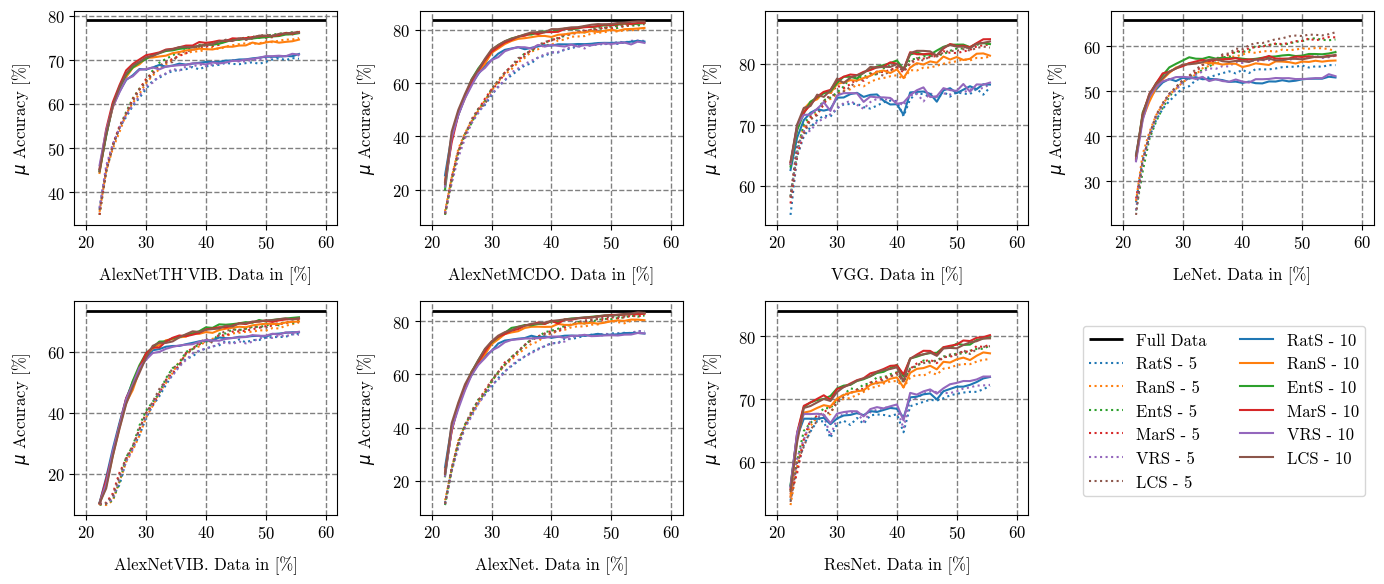

In [8]:

MODELS = ['CustomNet', 'AlexNetMCDO', 'VGG', 'LeNet', 'AlexNetVIB', 'AlexNet', 'ResNet']

def al_train_df_per_model(model, test_or_train_path:str = "train", file_regex: str = "500-**"):
    al_train_dfs = {} 
    train_query_path_stg = get_query_path_stg(test_or_train_path, file_regex)
    for query_strategy, _ in train_query_path_stg[model].items():
        al_train_dfs[query_strategy] = [pd.read_csv(filename, index_col=None, header=0) for filename in train_query_path_stg[model][query_strategy]]
    
    return al_train_dfs

fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(14, 6))
axes = axes.flatten()

cols = ["Evaluation Accuracy"]
labels = ["(a)", "(b)", "(c)", "(d)", "(e)", "(f)", "(g)"]

legend_handles = []  # Store handles for legend
legend_labels = []   # Store labels for legend

for idx, model in enumerate(MODELS):
    ax = axes[idx]

    for col in cols:
        _col = col
        if col == "Evaluation Accuracy":
            _col = "Validation Accuracy"
        df_mean = np.mean([df[_col].values for df in train_dfs[model]], axis=0) 
        # ax.hlines(df_mean[-1], xmin=20, xmax=60, linewidth=2, color='black', label=replace_customnet(model_name=model))
        hline = ax.hlines(df_mean[-1], xmin=20, xmax=60, linewidth=2, color='black', label=replace_customnet(model_name=model))
        print("Model:", replace_customnet(model_name=model))
        
        if idx == 0:  # Add legend entry only for the first subplot
            legend_handles.append(hline)
            legend_labels.append("Full Data")


        al_train_dfs = al_train_df_per_model(model=model, file_regex="data-**")
        for qs_name, df_s in al_train_dfs.items():
            df_mean = np.mean([df[col].values for df in df_s], axis=0) 
            # print(qs_name, f"({np.round(df_mean[-1], 2)})")

            # Plot uncertainty sampling curves
            line, = ax.plot(df_s[0]["Data Percentage"], df_mean, linestyle="dotted", color=Color.from_model_name(short_sampling_name[qs_name]))

            # Collect legend entries (only for first subplot)
            if qs_name not in legend_labels and idx == 0:
                legend_handles.append(line)
                legend_labels.append(f"{short_sampling_name[qs_name]} - 5")

        ax.grid(True, which='both', axis='both', color='gray', linestyle='--', linewidth=1) 
        ax.set_ylabel(r"$\mu$ Accuracy [%]", fontsize=12, labelpad=10)

        # AL Uncertainty sampling plot
        al_train_dfs = al_train_df_per_model(model=model)
        for qs_name, df_s in al_train_dfs.items():
            df_mean = np.mean([df[col].values for df in df_s], axis=0) 
            print(qs_name, f"({np.round(df_mean[-1], 2)})")

            # Plot uncertainty sampling curves
            line, = ax.plot(df_s[0]["Data Percentage"], df_mean, color=Color.from_model_name(short_sampling_name[qs_name]))

            # Collect legend entries (only for first subplot)
            if qs_name not in legend_labels and idx == 0:
                legend_handles.append(line)
                legend_labels.append(f"{short_sampling_name[qs_name]} - 10")

        print("=========================================")

        

    model = replace_customnet(model_name=model)
    ax.set_xlabel(f"{model}. Data in [%]", fontsize=12, labelpad=10)

fig.delaxes(axes[-1])
fig.legend(legend_handles, legend_labels, loc="center", bbox_to_anchor=(0.88, 0.3), ncol=2)

plt.tight_layout()

# plt.savefig("/workspace/images/al_train_compare_epoch.svg")
plt.show()


In [ ]:
al_train_df_per_model("CustomNet")

ratio_sampling (71.31)
random_sampling (74.55)
entropy_sampling (76.02)
margin_sampling (76.29)
variance_reduction_sampling (71.17)
least_confidence_sampling (76.15)
Model: AlexNetTH_VIB (78.92)
ratio_sampling (75.62)
random_sampling (80.76)
entropy_sampling (82.56)
margin_sampling (82.68)
variance_reduction_sampling (75.12)
least_confidence_sampling (83.16)
Model: AlexNetMCDO (83.59)
ratio_sampling (76.56)
random_sampling (81.3)
entropy_sampling (83.2)
margin_sampling (84.0)
variance_reduction_sampling (76.88)
least_confidence_sampling (83.63)
Model: VGG (87.09)
ratio_sampling (53.05)
random_sampling (56.82)
entropy_sampling (58.7)
margin_sampling (57.9)
variance_reduction_sampling (53.34)
least_confidence_sampling (58.08)
Model: LeNet (65.74)
ratio_sampling (66.38)
random_sampling (69.9)
entropy_sampling (71.31)
margin_sampling (70.82)
variance_reduction_sampling (66.55)
least_confidence_sampling (71.0)
Model: AlexNetVIB (73.51)
ratio_sampling (75.32)
random_sampling (80.36)
entropy_

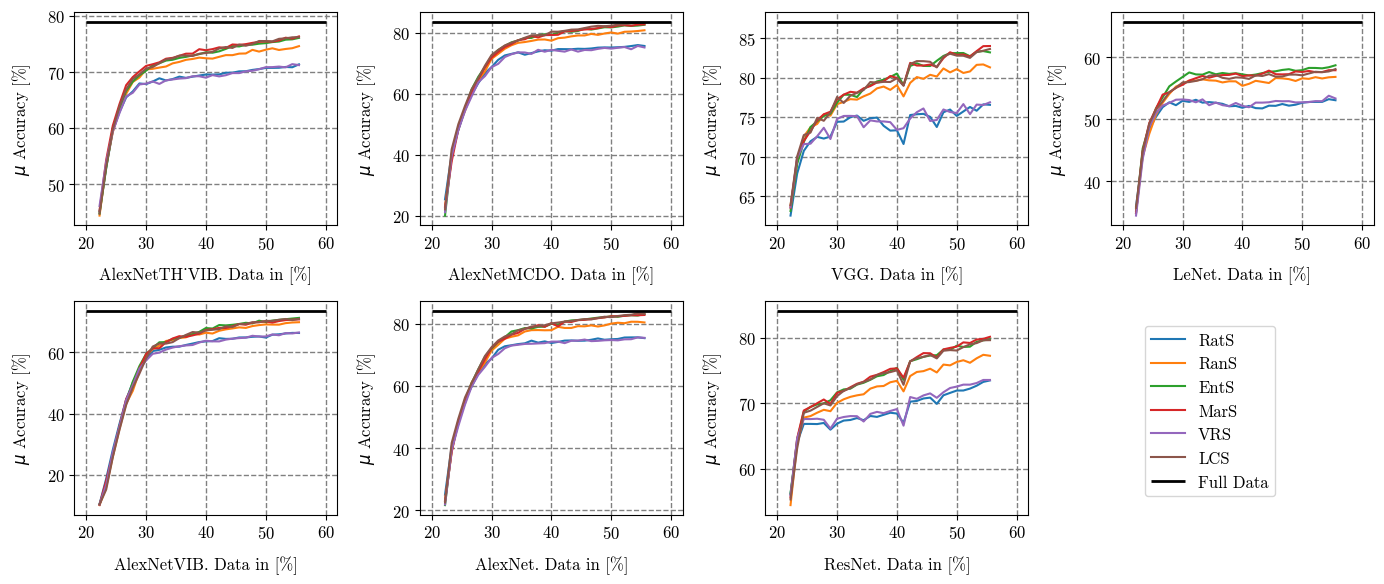

In [16]:

MODELS = ['CustomNet', 'AlexNetMCDO', 'VGG', 'LeNet', 'AlexNetVIB', 'AlexNet', 'ResNet']

def al_train_df_per_model(model):
    al_train_dfs = {} 
    train_query_path_stg = get_query_path_stg()
    for query_strategy, _ in train_query_path_stg[model].items():
        al_train_dfs[query_strategy] = [pd.read_csv(filename, index_col=None, header=0) for filename in train_query_path_stg[model][query_strategy]]
    
    return al_train_dfs

fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(14, 6))
axes = axes.flatten()

cols = ["Evaluation Accuracy"]
labels = ["(a)", "(b)", "(c)", "(d)", "(e)", "(f)", "(g)"]

legend_handles = []  # Store handles for legend
legend_labels = []   # Store labels for legend

for idx, model in enumerate(MODELS):
    ax = axes[idx]

    for col in cols:
        # AL Uncertainty sampling plot
        al_train_dfs = al_train_df_per_model(model)
        for qs_name, df_s in al_train_dfs.items():
            df_mean = np.mean([df[col].values for df in df_s], axis=0) 
            print(qs_name, f"({np.round(df_mean[-1], 2)})")

            # Plot uncertainty sampling curves
            line, = ax.plot(df_s[0]["Data Percentage"], df_mean, label=short_sampling_name[qs_name])

            # Collect legend entries (only for first subplot)
            if qs_name not in legend_labels and idx == 0:
                legend_handles.append(line)
                legend_labels.append(short_sampling_name[qs_name])
        
        _col = col
        if col == "Evaluation Accuracy":
            _col = "Validation Accuracy"
        df_mean = np.mean([df[_col].values for df in train_dfs[model]], axis=0) 
        # ax.hlines(df_mean[-1], xmin=20, xmax=60, linewidth=2, color='black', label=replace_customnet(model_name=model))
        hline = ax.hlines(df_mean[-1], xmin=20, xmax=60, linewidth=2, color='black', label=replace_customnet(model_name=model))
        print("Model:", replace_customnet(model_name=model), "("+str(round(df_mean[-1],2))+")")
        
        if idx == 0:  # Add legend entry only for the first subplot
            legend_handles.append(hline)
            legend_labels.append("Full Data")

    

        ax.grid(True, which='both', axis='both', color='gray', linestyle='--', linewidth=1) 
        ax.set_ylabel(r"$\mu$ Accuracy [%]", fontsize=12, labelpad=10)

    print("=========================================")

    model = replace_customnet(model_name=model)
    ax.set_xlabel(f"{model}. Data in [%]", fontsize=12, labelpad=10)

fig.delaxes(axes[-1])
fig.legend(legend_handles, legend_labels, loc="center", bbox_to_anchor=(0.87, 0.3))

plt.tight_layout()

# plt.savefig("/workspace/images/al_train_50_perc.svg")
plt.show()


In [ ]:

MODELS = ['CustomNet', 'AlexNetMCDO', 'VGG', 'LeNet', 'AlexNetVIB', 'AlexNet', 'ResNet']

def al_train_df_per_model(model):
    al_train_dfs = {} 
    train_query_path_stg = get_query_path_stg()
    for query_strategy, _ in train_query_path_stg[model].items():
        al_train_dfs[query_strategy] = [pd.read_csv(filename, index_col=None, header=0) for filename in train_query_path_stg[model][query_strategy]]
    
    return al_train_dfs

fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(14, 6))
axes = axes.flatten()

cols = ["Top 1 Error"]
labels = ["(a)", "(b)", "(c)", "(d)", "(e)", "(f)", "(g)"]

legend_handles = []  # Store handles for legend
legend_labels = []   # Store labels for legend

for idx, model in enumerate(MODELS):
    ax = axes[idx]

    # print("Model:", replace_customnet(model_name=model))
    for col in cols:
        # AL Uncertainty sampling plot
        al_train_dfs = al_train_df_per_model(model)
        for qs_name, df_s in al_train_dfs.items():
            df_mean = np.mean([df[col].values for df in df_s], axis=0) * 100
            # print(qs_name, f"({np.round(df_mean[-1], 2)})")

            # Plot uncertainty sampling curves
            line, = ax.plot(range(len(df_mean)), df_mean, label=short_sampling_name[qs_name])

            # Collect legend entries (only for first subplot)
            if qs_name not in legend_labels and idx == 0:
                legend_handles.append(line)
                legend_labels.append(short_sampling_name[qs_name])

        ax.grid(True, which='both', axis='both', color='gray', linestyle='--', linewidth=1) 
        ax.set_ylabel("Top-1-Error [%]", fontsize=12, labelpad=10)
        ax.set_title(replace_customnet(model_name=model), fontsize=12)

    ax.set_xlabel(f"Epoch", fontsize=12, labelpad=10)
    # print("====================================================")

fig.delaxes(axes[-1])
fig.legend(legend_handles, legend_labels, loc="center", bbox_to_anchor=(0.87, 0.3))

plt.tight_layout()

# plt.savefig("/workspace/images/top_1_error.svg")
plt.show()


In [ ]:

MODELS = ['CustomNet', 'AlexNetMCDO', 'VGG', 'LeNet', 'AlexNetVIB', 'AlexNet', 'ResNet']

def al_train_df_per_model(model):
    al_train_dfs = {} 
    train_query_path_stg = get_query_path_stg()
    for query_strategy, _ in train_query_path_stg[model].items():
        al_train_dfs[query_strategy] = [pd.read_csv(filename, index_col=None, header=0) for filename in train_query_path_stg[model][query_strategy]]
    
    return al_train_dfs

fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(14, 6))
axes = axes.flatten()

cols = ["Top 5 Error"]
labels = ["(a)", "(b)", "(c)", "(d)", "(e)", "(f)", "(g)"]

legend_handles = []  # Store handles for legend
legend_labels = []   # Store labels for legend

for idx, model in enumerate(MODELS):
    ax = axes[idx]

    print("Model:", replace_customnet(model_name=model))
    for col in cols:
        # AL Uncertainty sampling plot
        al_train_dfs = al_train_df_per_model(model)
        for qs_name, df_s in al_train_dfs.items():
            df_mean = np.mean([df[col].values for df in df_s], axis=0) * 100
            print(qs_name, f"({np.round(df_mean[-1], 2)})")

            # Plot uncertainty sampling curves
            line, = ax.plot(range(len(df_mean)), df_mean, label=short_sampling_name[qs_name])

            # Collect legend entries (only for first subplot)
            if qs_name not in legend_labels and idx == 0:
                legend_handles.append(line)
                legend_labels.append(short_sampling_name[qs_name])

        ax.grid(True, which='both', axis='both', color='gray', linestyle='--', linewidth=1) 
        ax.set_ylabel("Top-5-Error [%]", fontsize=12, labelpad=10)
        ax.set_title(replace_customnet(model_name=model), fontsize=12)
    
    print("=========================================================")

    ax.set_xlabel(f"Epoch", fontsize=12, labelpad=10)

fig.delaxes(axes[-1])
fig.legend(legend_handles, legend_labels, loc="center", bbox_to_anchor=(0.87, 0.3))

plt.tight_layout()

# plt.savefig("/workspace/images/top_5_error.svg")
plt.show()


In [ ]:
MODELS = ['CustomNet', 'AlexNetMCDO', 'VGG', 'LeNet', 'AlexNetVIB', 'AlexNet', 'ResNet']


def al_train_df_per_model(model):
    al_train_dfs = {} 
    train_query_path_stg = get_query_path_stg()
    for query_strategy, _ in train_query_path_stg[model].items():
        al_train_dfs[query_strategy] = [pd.read_csv(filename, index_col=None, header=0) for filename in train_query_path_stg[model][query_strategy]]
    return al_train_dfs


fig, ax = plt.subplots(figsize=(12, 6))


bar_width = 0.12 
x = np.arange(len(MODELS)) 

legend_handles = [] 
legend_labels = [] 

for i, model in enumerate(MODELS):
    al_train_dfs = al_train_df_per_model(model)
    
    # print(replace_customnet(model))
    for j, (qs_name, df_s) in enumerate(al_train_dfs.items()):
        df_sum = np.round(np.sum([df["Query Times"].values for df in df_s]) / 60, 2)

        if model == "CustomNet":
            df_sum *= 1.17

        
        # print(qs_name, f"({round(df_sum, 2)})") 

        # Plot bars for each model & query strategy
        label_name = short_sampling_name[qs_name]
        bar = ax.bar(x[i] + j * bar_width, df_sum, width=bar_width, label=label_name, color=Color.from_model_name(label_name))

        # Collect legend entries (only for first iteration)
        if i == 0:
            legend_handles.append(bar)
            legend_labels.append(label_name)
    # print("===================================================")

# Formatting
ax.set_xticks(x + (bar_width * (len(al_train_dfs) / 2)))
ax.set_xticklabels([replace_customnet(m) for m in MODELS], rotation=25)
ax.set_ylabel("Total Query Time (min)", fontsize=12)
#ax.set_title("Query Times for Different Models and Query Strategies", fontsize=14)
ax.grid(axis='y', linestyle='--', linewidth=0.7, alpha=0.7)

# Add a legend outside the plot
ax.legend(legend_handles, legend_labels, loc="upper left", bbox_to_anchor=(0.9, 1))
plt.tight_layout()

# plt.savefig("/workspace/images/query_time_efficiency.svg")
plt.show()


In [ ]:
MODELS = ['CustomNet', 'AlexNetMCDO', 'VGG', 'LeNet', 'AlexNetVIB', 'AlexNet', 'ResNet']

def al_train_df_per_model(model):
    al_train_dfs = {} 
    train_query_path_stg = get_query_path_stg()
    for query_strategy, _ in train_query_path_stg[model].items():
        al_train_dfs[query_strategy] = [pd.read_csv(filename, index_col=None, header=0) for filename in train_query_path_stg[model][query_strategy]]
    
    return al_train_dfs

fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(14, 6))
axes = axes.flatten()

cols = ["Diversity Metrics"]
labels = ["(a)", "(b)", "(c)", "(d)", "(e)", "(f)", "(g)"]

legend_handles = []  # Store handles for legend
legend_labels = []   # Store labels for legend

for idx, model in enumerate(MODELS):
    ax = axes[idx]

    for col in cols:
        al_train_dfs = al_train_df_per_model(model)
        
        for qs_name, df_s in al_train_dfs.items():
            df_mean = np.mean([df[col].values for df in df_s], axis=0) 

            # Plot KDE with valid legend handle
            sns.kdeplot(x=df_mean, ax=ax, label=short_sampling_name[qs_name])

            # Collect legend entries (only for first subplot)
            if qs_name not in legend_labels and idx == 0:
                legend_labels.append(short_sampling_name[qs_name])

        ax.grid(True, which='both', axis='both', color='gray', linestyle='--', linewidth=1) 
        ax.set_ylabel("Density", fontsize=12, labelpad=10)

    model = replace_customnet(model_name=model)
    ax.set_xlabel(f"{model}. (1 - Cosine Similarity)", fontsize=12, labelpad=10)

# Remove the last empty subplot
fig.delaxes(axes[-1])

# Create a legend outside the plot
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="center", bbox_to_anchor=(0.87, 0.3))

plt.tight_layout()
plt.savefig("/workspace/images/query_strategy_similarity.svg")
plt.show()


In [ ]:
cc = al_train_df_per_model("CustomNet")["random_sampling"]
print(np.sum([df["Query Times"].values for df in cc]))
print(np.sum([df["Query Times"].values for df in cc], axis=1))

In [ ]:
al_train_df_per_model("LeNet")["ratio_sampling"][0].head()

In [ ]:
al_train_df_per_model("CustomNet").keys()

In [ ]:

# Example data: diversity scores for different models & strategies
np.random.seed(42)
data = {
    "Model": np.repeat(["Model A", "Model B", "Model C"], 100),
    "Strategy": np.tile(["Entropy", "Margin", "Least Confident"], 100),
    "Diversity Score": np.concatenate([
        np.random.beta(2, 5, 100),  # Model A - lower diversity
        np.random.beta(5, 2, 100),  # Model B - higher diversity
        np.random.beta(3, 3, 100),  # Model C - moderate diversity
    ])
}

# Convert to DataFrame
df = pd.DataFrame(data)

# Plot KDE with seaborn
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df, x="Diversity Score", hue="Model", fill=True, alpha=0.3)

# Customize plot
plt.title("Diversity Score Distribution Across Models", fontsize=14)
plt.xlabel("Diversity Score (1 - Cosine Similarity)", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.legend(title="Model")
plt.show()


In [ ]:
al_test_df_per_stg = get_query_path_stg("test")

In [ ]:
al_test_df_per_stg

In [ ]:
# Test Data to latex

# test_cols = ['Test Accuracy', 'Entropy Reduction', 'Model Confidence', 'Top 1 Error', 'Top 5 Error']
# cols_to_multiply = ['Model Confidence', 'Top 1 Error', 'Top 5 Error']
# index_short = ["RatS", "RanS", "EntS", "MarS", "VRS", "LCS"]
# 
# for model, query_data_dict in al_test_df_per_stg.items():
#     latex_dfs = []
#     for qs, file_paths in query_data_dict.items():
# 
#         dfs = [pd.read_csv(file_path, index_col=None, header=0) for file_path in file_paths]
# 
#         mean_df = pd.concat(dfs).groupby(level=0).mean()
#         mean_df[cols_to_multiply] = mean_df[cols_to_multiply] * 100
# 
#         std_df = pd.concat(dfs).groupby(level=0).std()
#         std_df[cols_to_multiply] = std_df[cols_to_multiply] * 100
# 
#         mean_df = mean_df[test_cols].round(2)
#         std_df = std_df[test_cols].round(2)
# 
#         latex_df = "$" + mean_df.astype(str) + " \\pm " + std_df.astype(str) + "$"
#         latex_dfs.append(latex_df)
# 
#     # print(replace_customnet(model_name=model))
#     combined_latex_df = pd.concat(latex_dfs, keys=list(query_data_dict)).reset_index(level=0)
# 
#     # print(combined_latex_df.to_latex(index=False))
#     # print("================================================================================")
# 

In [ ]:
print(pd.concat(latex_dfs, keys=list(query_data_dict)).to_latex())

In [ ]:
pd.concat(dfs)

In [ ]:
pd.concat(dfs).groupby(level=0).mean().round(2)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score

# Generate synthetic dataset
X, y = make_classification(n_samples=1000, n_features=2, n_informative=2, n_redundant=0, random_state=42)
X_train, X_pool, y_train, y_pool = train_test_split(X, y, test_size=0.9, random_state=42)  # Small initial training set

# Active learning loop parameters
num_queries = 20  # Number of samples to add per iteration
iterations = 10

# Initialize classifier
model = SVC(probability=True, kernel='rbf', random_state=42)

for iteration in range(iterations):
    # Train model on current labeled dataset
    model.fit(X_train, y_train)

    # Predict probabilities for the unlabeled pool
    probs = model.predict_proba(X_pool)
    uncertainty = np.max(probs, axis=1)  # Least confidence method (lower = more uncertain)

    # Select the most uncertain samples
    uncertain_indices = np.argsort(uncertainty)[:5 * num_queries]  # Take a subset for diversity

    # Use clustering to select the most representative among the uncertain ones
    selected_X = X_pool[uncertain_indices]
    kmeans = KMeans(n_clusters=num_queries, random_state=42, n_init=10)
    kmeans.fit(selected_X)
    cluster_centers = kmeans.cluster_centers_

    # Find closest points to cluster centers
    representative_indices = np.array([
        uncertain_indices[np.argmin(np.linalg.norm(selected_X - center, axis=1))]
        for center in cluster_centers
    ])

    # Add selected samples to training set
    X_train = np.vstack((X_train, X_pool[representative_indices]))
    y_train = np.hstack((y_train, y_pool[representative_indices]))

    # Remove selected samples from pool
    X_pool = np.delete(X_pool, representative_indices, axis=0)
    y_pool = np.delete(y_pool, representative_indices, axis=0)

    # Evaluate performance
    y_pred = model.predict(X_train)
    acc = accuracy_score(y_train, y_pred)
    print(f"Iteration {iteration + 1}: Training Accuracy = {acc:.4f}")

# Plot final decision boundary
xx, yy = np.meshgrid(np.linspace(X[:, 0].min(), X[:, 0].max(), 100),
                     np.linspace(X[:, 1].min(), X[:, 1].max(), 100))
Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, alpha=0.3)
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, edgecolors='k', label="Labeled Data")
plt.scatter(X_pool[:, 0], X_pool[:, 1], c='gray', alpha=0.2, label="Unlabeled Data")
plt.legend()
plt.title("Active Learning with Representativeness")
plt.show()


In [ ]:

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score

# Generate synthetic dataset
X, y = make_classification(n_samples=1000, n_features=2, n_informative=2, n_redundant=0, random_state=42)
X_train, X_pool, y_train, y_pool = train_test_split(X, y, test_size=0.9, random_state=42)  # Small initial labeled set

# Active learning loop parameters
num_queries = 20  # Number of samples to add per iteration
iterations = 10

# Initialize classifier
model = SVC(probability=True, kernel='rbf', random_state=42)

for iteration in range(iterations):
    # Train model on current labeled dataset
    model.fit(X_train, y_train)

    # Cluster the entire unlabeled pool to identify structure
    kmeans = KMeans(n_clusters=num_queries, random_state=42, n_init=10)
    kmeans.fit(X_pool)
    cluster_centers = kmeans.cluster_centers_

    # Find the closest point in each cluster to the centroid (representative sample)
    representative_indices = np.array([
        np.argmin(np.linalg.norm(X_pool - center, axis=1))
        for center in cluster_centers
    ])

    # Add selected representative samples to training set
    X_train = np.vstack((X_train, X_pool[representative_indices]))
    y_train = np.hstack((y_train, y_pool[representative_indices]))

    # Remove selected samples from pool
    X_pool = np.delete(X_pool, representative_indices, axis=0)
    y_pool = np.delete(y_pool, representative_indices, axis=0)

    # Evaluate performance
    y_pred = model.predict(X_train)
    acc = accuracy_score(y_train, y_pred)
    print(f"Iteration {iteration + 1}: Training Accuracy = {acc:.4f}")

# Plot final decision boundary
xx, yy = np.meshgrid(np.linspace(X[:, 0].min(), X[:, 0].max(), 100),
                     np.linspace(X[:, 1].min(), X[:, 1].max(), 100))
Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, alpha=0.3)
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, edgecolors='k', label="Labeled Data")
plt.scatter(X_pool[:, 0], X_pool[:, 1], c='gray', alpha=0.2, label="Unlabeled Data")
plt.legend()
plt.title("Active Learning with Representativeness")
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score

# Generate synthetic dataset
X, y = make_classification(n_samples=1000, n_features=2, n_informative=2, n_redundant=0, random_state=42)
X_train, X_pool, y_train, y_pool = train_test_split(X, y, test_size=0.9, random_state=42)  # Small initial labeled set

# Active learning loop parameters
num_queries = 20  # Number of samples to add per iteration
reduced_clusters = num_queries // 2  # Reduce number of clusters
iterations = 10

# Initialize classifier
model = SVC(probability=True, kernel='rbf', random_state=42)

for iteration in range(iterations):
    # Train model on current labeled dataset
    model.fit(X_train, y_train)

    # Cluster a subset of the unlabeled pool
    kmeans = KMeans(n_clusters=reduced_clusters, random_state=42, n_init=10)
    kmeans.fit(X_pool)
    cluster_centers = kmeans.cluster_centers_

    # Find the closest point in each cluster to the centroid
    representative_indices = []
    for center in cluster_centers:
        closest_idx = np.argmin(np.linalg.norm(X_pool - center, axis=1))
        representative_indices.append(closest_idx)

    # Randomly sample from the selected representative points to increase diversity
    representative_indices = np.random.choice(representative_indices, size=min(num_queries, len(representative_indices)), replace=False)

    # Add selected representative samples to training set
    X_train = np.vstack((X_train, X_pool[representative_indices]))
    y_train = np.hstack((y_train, y_pool[representative_indices]))

    # Remove selected samples from pool
    X_pool = np.delete(X_pool, representative_indices, axis=0)
    y_pool = np.delete(y_pool, representative_indices, axis=0)

    # Evaluate performance
    y_pred = model.predict(X_train)
    acc = accuracy_score(y_train, y_pred)
    print(f"Iteration {iteration + 1}: Training Accuracy = {acc:.4f}")

# Plot final decision boundary
xx, yy = np.meshgrid(np.linspace(X[:, 0].min(), X[:, 0].max(), 100),
                     np.linspace(X[:, 1].min(), X[:, 1].max(), 100))
Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, alpha=0.3)
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, edgecolors='k', label="Labeled Data")
plt.scatter(X_pool[:, 0], X_pool[:, 1], c='gray', alpha=0.2, label="Unlabeled Data")
plt.legend()
plt.title("Active Learning with Reduced Cluster Selection")
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score

# Generate synthetic dataset
X, y = make_classification(n_samples=1000, n_features=2, n_informative=2, n_redundant=0, random_state=42)
X_train, X_pool, y_train, y_pool = train_test_split(X, y, test_size=0.9, random_state=42)  # Small initial labeled set

# Active learning loop parameters
num_queries = 20  # Number of samples to add per iteration
fixed_clusters = 3  # Set to exactly 3 clusters
iterations = 10

# Initialize classifier
model = SVC(probability=True, kernel='rbf', random_state=42)

for iteration in range(iterations):
    # Train model on current labeled dataset
    model.fit(X_train, y_train)

    # Cluster the unlabeled pool into exactly 3 clusters
    kmeans = KMeans(n_clusters=fixed_clusters, random_state=42, n_init=10)
    kmeans.fit(X_pool)
    cluster_centers = kmeans.cluster_centers_

    # Find the closest point in each cluster to the centroid (representative sample)
    representative_indices = []
    for center in cluster_centers:
        closest_idx = np.argmin(np.linalg.norm(X_pool - center, axis=1))
        representative_indices.append(closest_idx)

    # Randomly sample more points from each cluster for diversity
    selected_indices = []
    for cluster_id in range(fixed_clusters):
        cluster_points = np.where(kmeans.labels_ == cluster_id)[0]
        sampled = np.random.choice(cluster_points, size=min(num_queries // fixed_clusters, len(cluster_points)), replace=False)
        selected_indices.extend(sampled)

    # Add selected representative samples to training set
    X_train = np.vstack((X_train, X_pool[selected_indices]))
    y_train = np.hstack((y_train, y_pool[selected_indices]))

    # Remove selected samples from pool
    X_pool = np.delete(X_pool, selected_indices, axis=0)
    y_pool = np.delete(y_pool, selected_indices, axis=0)

    # Evaluate performance
    y_pred = model.predict(X_train)
    acc = accuracy_score(y_train, y_pred)
    print(f"Iteration {iteration + 1}: Training Accuracy = {acc:.4f}")

# Plot final decision boundary
xx, yy = np.meshgrid(np.linspace(X[:, 0].min(), X[:, 0].max(), 100),
                     np.linspace(X[:, 1].min(), X[:, 1].max(), 100))
Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, alpha=0.3)
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, edgecolors='k', label="Labeled Data")
plt.scatter(X_pool[:, 0], X_pool[:, 1], c='gray', alpha=0.2, label="Unlabeled Data")
plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], c='red', marker='X', s=100, label="Cluster Centers")
plt.legend()
plt.title("Active Learning with Three Clusters")
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Function to generate circular clusters
def generate_circular_clusters(n_samples=300, n_clusters=3, radius=10, noise=0.5):
    np.random.seed(42)
    angles = np.linspace(0, 2 * np.pi, n_clusters, endpoint=False)
    centers = [(radius * np.cos(a), radius * np.sin(a)) for a in angles]
    
    data = []
    labels = []
    for i, (cx, cy) in enumerate(centers):
        r = np.random.normal(loc=radius/4, scale=noise, size=n_samples // n_clusters)
        theta = np.random.uniform(0, 2 * np.pi, size=n_samples // n_clusters)
        x = cx + r * np.cos(theta)
        y = cy + r * np.sin(theta)
        data.append(np.column_stack([x, y]))
        labels.extend([i] * (n_samples // n_clusters))
    
    return np.vstack(data), np.array(labels)

# Generate circular clusters
data, true_labels = generate_circular_clusters()

# Apply K-means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(data)
predicted_labels = kmeans.labels_

# Select representative samples (closest to cluster centroids)
representative_samples = []
for i in range(3):
    cluster_points = data[predicted_labels == i]
    centroid = kmeans.cluster_centers_[i]
    distances = np.linalg.norm(cluster_points - centroid, axis=1)
    representative_samples.append(cluster_points[np.argmin(distances)])
representative_samples = np.array(representative_samples)

# Plot the clusters and representative points
plt.figure(figsize=(8, 8))
plt.scatter(data[:, 0], data[:, 1], c=predicted_labels, cmap='viridis', alpha=0.5, label='Cluster Points')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='red', marker='X', s=200, label='Centroids')
plt.scatter(representative_samples[:, 0], representative_samples[:, 1], c='blue', marker='o', s=150, edgecolors='black', label='Representative Samples')
plt.legend()
plt.title('Cluster-Based Representativeness Sampling')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Function to generate circular clusters
def generate_circular_clusters(n_samples=300, n_clusters=3, radius=10, noise=0.5):
    np.random.seed(42)
    angles = np.linspace(0, 2 * np.pi, n_clusters, endpoint=False)
    centers = [(radius * np.cos(a), radius * np.sin(a)) for a in angles]
    
    data = []
    for cx, cy in centers:
        r = np.random.normal(loc=radius/4, scale=noise, size=n_samples // n_clusters)
        theta = np.random.uniform(0, 2 * np.pi, size=n_samples // n_clusters)
        x = cx + r * np.cos(theta)
        y = cy + r * np.sin(theta)
        data.append(np.column_stack([x, y]))
    
    return np.vstack(data)

# Generate circular clusters
data = generate_circular_clusters()

# Apply K-means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(data)
predicted_labels = kmeans.labels_

# Select representative samples (closest to cluster centroids)
representative_samples = []
for i in range(3):
    cluster_points = data[predicted_labels == i]
    centroid = kmeans.cluster_centers_[i]
    distances = np.linalg.norm(cluster_points - centroid, axis=1)
    representative_samples.append(cluster_points[np.argmin(distances)])
representative_samples = np.array(representative_samples)

# Plot only representative points
plt.figure(figsize=(8, 8))
plt.scatter(representative_samples[:, 0], representative_samples[:, 1], c='blue', marker='o', s=150, edgecolors='black', label='Representative Samples')
plt.legend()
plt.title('Cluster Representativeness')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.show()

